# 2a - Create Sentinel 2 time series for McKinley Mine seeding units
This notebook creates Sentinel 2 time series of NDVI or other band ratios for each seeding unit created by notebook 1.

In [1]:
# Import libraries
import os
import datetime
from datetime import date
import configparser
import copy

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

# Import custom module for this project
from vegrestoretools import FisToDataframe, EvalScripts, FisClean

from sentinelhub import SHConfig, FisRequest, BBox, Geometry, CRS, WcsRequest, CustomUrlParam, \
    DataCollection, HistogramType
from sentinelhub.time_utils import iso_to_datetime, parse_time

In [2]:
# Read SentinelHub configuration ID's from your local ini file
config_ini = configparser.ConfigParser()
config_ini.read('sentinel2_setup.ini')

# Populate a SentinelHub configuration object with the ID's from the local ini file
config = SHConfig()
config.instance_id = config_ini['Config']['instance_id'] # Instance ID for the Configuration
config.sh_client_id = config_ini['Config']['sh_client_id'] # Credentials from the OAuth client
config.sh_client_secret = config_ini['Config']['sh_client_secret']
config.save()

In [3]:
# Other parameters
startDate = '2017-01-01'

In [4]:
# Set working directory
os.chdir(os.path.join('D:/',
                      'McKinley'))

## Restore seeding unit geodataframe

In [5]:
%store -r mckinley_seeding_subset_PARlo
mckinley_seeding_subset_PARlo

,Mine_Area,Start_Year,End_Year,GIS_Acre2,Agreement,Seed_Type,TYPE,geometry,PAR
172,9N,2017,2017,8.774365,Permanent Program,Seed,Seeding,"POLYGON ((2401075.334 1683413.202, 2401068.257...",0.007403
816,None,2013,2013,55.702517,Permanent Program,Seed,Seeding,"POLYGON ((2378986.229 1702322.589, 2378982.791...",0.008140
913,None,2013,2013,45.834100,Permanent Program,Seed,Seeding,"MULTIPOLYGON (((2403966.161 1702249.371, 24039...",0.008526
916,None,2013,2013,166.414201,Permanent Program,Seed,Seeding,"POLYGON ((2398388.920 1703880.919, 2398403.538...",0.009537
1265,10,2013,2013,5.505459,Permanent Program,Reseed,Reseeding,"POLYGON ((2385163.827 1693999.402, 2385155.351...",0.009982
1314,11,2013,2013,96.634051,Permanent Program,Seed,Seeding,"POLYGON ((2399754.113 1695408.235, 2399762.904...",0.003032
1319,11,2013,2013,11.045688,Permanent Program,Seed,Seeding,"POLYGON ((2399974.214 1696112.931, 2399974.230...",0.009493
1558,None,2014,2014,83.281620,Permanent Program,Reseed,Reseeding,"POLYGON ((2402224.363 1715573.020, 2402213.169...",0.005979
1588,None,2014,2014,7.462737,Permanent Program,Reseed,Reseeding,"POLYGON ((2404782.569 1706591.781, 2404802.102...",0.009511
1589,None,2014,2014,10.456143,Permanent Program,Reseed,Reseeding,"POLYGON ((2409735.763 1703942.635, 2409767.743...",0.007148


## Run SentinelHub Statistical Info Service (FIS) query

In [6]:
seeding_aois = mckinley_seeding_subset_PARlo

# Convert seeding polygons to WGS84
seeding_aois = seeding_aois.to_crs("EPSG:4326")

# Explode multipolygons to polygons to query with FIS request
seeding_aois_exploded = seeding_aois.explode()

# Create empty list to store results for all polygons
output_list = []

# Loop over each polygon
for index, row in seeding_aois_exploded.iterrows():

    # Status message
    print('Now processing Seeding Unit Index: ' + str(index[0]))

    # Setup parameters for FIS request
    geometry_list = Geometry(row.geometry, CRS.WGS84)
    time_interval = (startDate, date.today())

    # Retrieve custom script to pass to SentinelHub from vegrestoretools module
    evalscript = EvalScripts('Sentinel_2_NDVI')

    # Build FIS request
    fis_request = FisRequest(
        data_collection=DataCollection.SENTINEL2_L2A,
        layer='BANDS-S2-L2A',
        geometry_list=[geometry_list],
        time=time_interval,
        resolution='100m',
        custom_url_params={CustomUrlParam.EVALSCRIPT: evalscript},
        config=config
    )

    # Run the FIS request
    fis_data = fis_request.get_data()

    # Convert the FIS result to a dataframe
    fis_df = FisToDataframe(fis_data)

    # Add the seeding unit ID to the dataframe
    fis_df['ID'] = index[0]

    # Append the df to the temporary list
    output_list.append(fis_df)

# Concatenate the VMU results into a single DF
fis_df_all_raw = pd.concat(output_list, axis=0)
fis_df_all_raw

Now processing Seeding Unit Index: 172
Now processing Seeding Unit Index: 816
Now processing Seeding Unit Index: 913
Now processing Seeding Unit Index: 913
Now processing Seeding Unit Index: 916
Now processing Seeding Unit Index: 1265
Now processing Seeding Unit Index: 1314
Now processing Seeding Unit Index: 1319
Now processing Seeding Unit Index: 1558
Now processing Seeding Unit Index: 1588
Now processing Seeding Unit Index: 1589
Now processing Seeding Unit Index: 1590
Now processing Seeding Unit Index: 1594
Now processing Seeding Unit Index: 1601
Now processing Seeding Unit Index: 1608
Now processing Seeding Unit Index: 1655
Now processing Seeding Unit Index: 2335
Now processing Seeding Unit Index: 2569
Now processing Seeding Unit Index: 2577
Now processing Seeding Unit Index: 2581
Now processing Seeding Unit Index: 2584
Now processing Seeding Unit Index: 2586
Now processing Seeding Unit Index: 2587
Now processing Seeding Unit Index: 2599
Now processing Seeding Unit Index: 2600
Now p

,date,min,max,mean,stDev,clm_mean,snw_mean,ID
0,2021-05-31,-0.011235,-0.003757,-0.008904,0.003023,1.0,100.500000,172
1,2021-05-29,0.097798,0.131056,0.108121,0.013485,0.0,0.000000,172
2,2021-05-26,0.040423,0.070128,0.054129,0.011546,1.0,0.000000,172
3,2021-05-24,0.093460,0.145264,0.110174,0.020601,0.0,0.000000,172
4,2021-05-21,-0.009225,0.016267,0.004830,0.009395,1.0,0.250000,172
...,...,...,...,...,...,...,...,...
536,2017-02-21,0.097730,0.149043,0.116268,0.010677,0.0,0.000000,2650
537,2017-02-14,-0.015393,0.025167,0.001644,0.007732,1.0,0.000000,2650
538,2017-02-04,-0.076547,0.513308,0.031470,0.118355,0.0,36.900000,2650
539,2017-02-01,-0.057969,0.070926,-0.026381,0.030557,0.0,83.100000,2650


## Clean up the FIS results

In [7]:
fis_df_all = FisClean(fis_df_all_raw)
fis_df_all

,ID,min,max,mean,stDev,clm_mean,snw_mean
date,,,,,,,
2017-02-21,172,0.105520,0.180918,0.127385,0.031246,0.0,0.0
2017-03-13,172,0.088841,0.165789,0.112921,0.030896,0.0,0.0
2017-04-12,172,0.075881,0.194825,0.120009,0.046784,0.0,0.0
2017-04-15,172,0.080686,0.205191,0.128965,0.048003,0.0,0.0
2017-04-22,172,0.073243,0.204739,0.124583,0.051938,0.0,0.0
...,...,...,...,...,...,...,...
2021-05-11,2650,0.087706,0.139262,0.117857,0.012438,0.0,0.0
2021-05-14,2650,0.101309,0.155668,0.132854,0.013285,0.0,0.0
2021-05-16,2650,0.093609,0.151339,0.128688,0.012489,0.0,0.0


## Plot the results

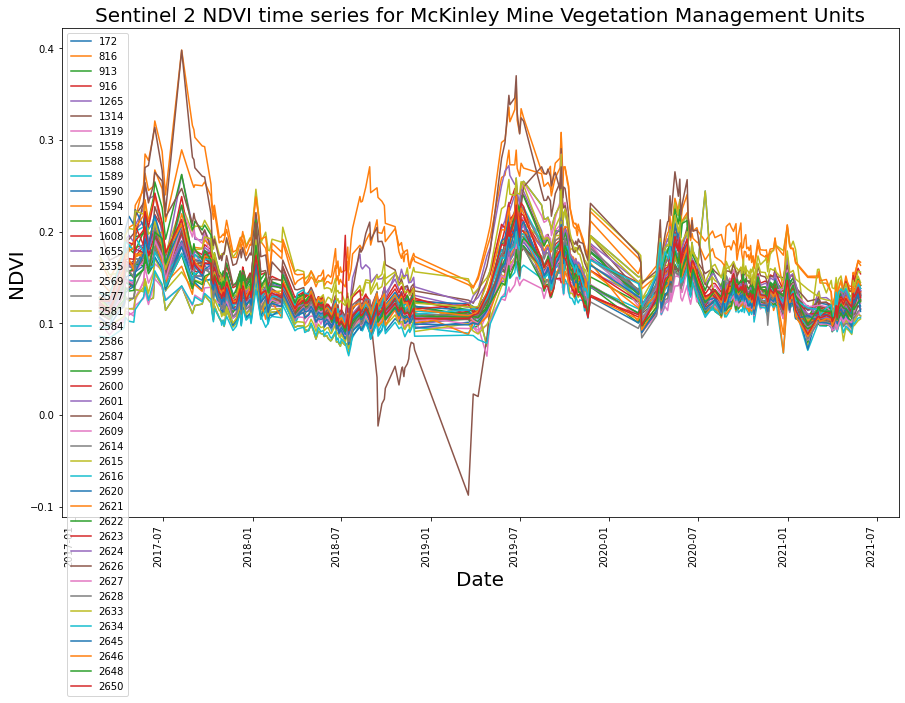

In [8]:
# Setup plot
fig, ax = plt.subplots(figsize=(15, 10))

# Build list of unique sites for legend
sites = fis_df_all.ID.unique()

fis_df_all.reset_index().groupby('ID').plot(x='date', y='mean', ax=ax)

# Legend and labels
plt.legend(sites)

plt.xlabel("Date", fontsize=20)
plt.ylabel("NDVI", fontsize=20)

ax.set_title(
    "Sentinel 2 NDVI time series for McKinley Mine Vegetation Management Units", fontsize=20)

plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right')

plt.show()

## Make DF tables consistent between Sentinel 2 and Landsat 8 data

In [9]:
sentinel_2_time_series = copy.deepcopy(fis_df_all)

# Drop columns
sentinel_2_time_series.drop(columns=['min', 'max', 'stDev', 'clm_mean', 'snw_mean'], inplace=True)

# Rename columns
sentinel_2_time_series.rename(
                columns={"mean": 'MeanNdvi'}, inplace=True)

sentinel_2_time_series.rename(
                columns={"ID": 'SuId'}, inplace=True)


sentinel_2_time_series

,SuId,MeanNdvi
date,,
2017-02-21,172,0.127385
2017-03-13,172,0.112921
2017-04-12,172,0.120009
2017-04-15,172,0.128965
2017-04-22,172,0.124583
...,...,...
2021-05-11,2650,0.117857
2021-05-14,2650,0.132854
2021-05-16,2650,0.128688


## Save the DF for use in subsequent notebooks

In [10]:
%store sentinel_2_time_series

Stored 'sentinel_2_time_series' (DataFrame)
